In [1]:
import pandas as pd
import os
import numpy as np
import scipy
import math
import random
import sklearn
import nltk
import warnings
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_curve, auc

In [2]:
# Set display options to show full content
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_rows', None)     # Show all rows
# pd.set_option('display.max_colwidth', None) # Show full content of each column

In [3]:
cwd = os.getcwd()
input = cwd + "\\input\\"

In [4]:
df_keywords = pd.read_csv(input+"cleaned\\keywords.csv")
df_movies = pd.read_csv(input+"cleaned\\movies_metadata.csv")
df_ratings = pd.read_csv(input+"ratings_small.csv")

In [5]:
# Drop these rows
condition = df_movies['genres'].isna()
df_movies = df_movies[~condition]
df_ratings = df_ratings[df_ratings['movieId'].isin(df_movies['id'])]

In [6]:
df_keywords.head()

,id,keywords
0,862,"jealousy, toy, boy, friendship, friends, rival..."
1,8844,"board game, disappearance, based on children's..."
2,15602,"fishing, best friend, duringcreditsstinger, ol..."
3,31357,"based on novel, interracial relationship, sing..."
4,11862,"baby, midlife crisis, confidence, aging, daugh..."


In [7]:
df_movies.head()

,id,title,release_date,adult,belongs_to_collection,genres,runtime,original_language,overview,production_companies,production_countries,spoken_languages,revenue,budget,vote_average,vote_count,popularity,keywords
0,862,Toy Story,1995-10-30,False,Toy Story Collection,"Animation, Comedy, Family",81.0,en,"Led by Woody, Andy's toys live happily in his ...",Pixar Animation Studios,United States of America,English,373554033.0,30000000,7.7,5415.0,21.946943,"jealousy, toy, boy, friendship, friends, rival..."
1,8844,Jumanji,1995-12-15,False,NaN,"Adventure, Fantasy, Family",104.0,en,When siblings Judy and Peter discover an encha...,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,"English, Français",262797249.0,65000000,6.9,2413.0,17.015539,"board game, disappearance, based on children's..."
2,15602,Grumpier Old Men,1995-12-22,False,Grumpy Old Men Collection,"Romance, Comedy",101.0,en,A family wedding reignites the ancient feud be...,"Warner Bros., Lancaster Gate",United States of America,English,71500000.0,0,6.5,92.0,11.712900,"fishing, best friend, duringcreditsstinger, ol..."
3,31357,Waiting to Exhale,1995-12-22,False,NaN,"Comedy, Drama, Romance",127.0,en,"Cheated on, mistreated and stepped on, the wom...",Twentieth Century Fox Film Corporation,United States of America,English,81452156.0,16000000,6.1,34.0,3.859495,"based on novel, interracial relationship, sing..."
4,11862,Father of the Bride Part II,1995-02-10,False,Father of the Bride Collection,Comedy,106.0,en,Just when George Banks has recovered from his ...,"Sandollar Productions, Touchstone Pictures",United States of America,English,76578911.0,0,5.7,173.0,8.387519,"baby, midlife crisis, confidence, aging, daugh..."


In [8]:
df_ratings.head()

,userId,movieId,rating,timestamp
10,1,1371,2.5,1260759135
11,1,1405,1.0,1260759203
13,1,2105,4.0,1260759139
15,1,2193,2.0,1260759198
16,1,2294,2.0,1260759108


In [9]:
users_interactions_count_df = df_ratings.groupby(['userId', 'movieId']).size().groupby('userId').size()
print('# users: %d' % len(users_interactions_count_df))

users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5]\
                                    .reset_index()[['userId']]


users_with_few_interactions_df = users_interactions_count_df[users_interactions_count_df < 5]\
                                    .reset_index()[['userId']]

print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))
print('# users with less than 5 interactions: %d' % len(users_with_few_interactions_df))

# users: 671
# users with at least 5 interactions: 668
# users with less than 5 interactions: 3


In [10]:
interactions_from_selected_users_df = df_ratings.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'userId',
               right_on = 'userId')

interactions_from_few_selected_users_df = df_ratings.merge(users_with_few_interactions_df, 
               how = 'right',
               left_on = 'userId',
               right_on = 'userId')

print('# of interactions from all users: %d' % len(df_ratings))
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))
print('# of interactions from users with less than 5 interactions: %d' % len(interactions_from_few_selected_users_df))

# of interactions from all users: 44940
# of interactions from users with at least 5 interactions: 44929
# of interactions from users with less than 5 interactions: 11


In [11]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['userId', 'movieId'])['rating'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)

# interactions_full_df = interactions_from_selected_users_df[['userId','movieId','rating']]
# interactions_full_df.head(10)

# of unique user/item interactions: 44929


,userId,movieId,rating
0,1,1371,1.807355
1,1,1405,1.000000
2,1,2105,2.321928
3,1,2193,1.584963
4,1,2294,1.584963
5,1,2455,1.807355
6,2,17,2.584963
7,2,62,2.000000
8,2,110,2.321928
9,2,144,2.000000


# 

# Top-N Accuracy Metric Evaluation

In [12]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['userId'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 35943
# interactions on Test set: 8986


In [13]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('userId')
interactions_train_indexed_df = interactions_train_df.set_index('userId')
interactions_test_indexed_df = interactions_test_df.set_index('userId')

In [14]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[person_id]['movieId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [15]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(df_movies['id'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['movieId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['movieId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['movieId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id,\
                                                                                    interactions_train_indexed_df), \
                                                                                    topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['movieId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['movieId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()

# 

# Collaborative Filtering model

In [16]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='userId', 
                                                          columns='movieId', 
                                                          values='rating').fillna(0)

users_items_pivot_matrix_df.head(10)

movieId,2,3,5,6,11,12,13,14,15,16,...,134158,134368,134569,134881,135536,140174,142507,148652,158238,160718
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,2.321928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [19]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<668x2679 sparse matrix of type '<class 'numpy.float64'>'
	with 35943 stored elements in Compressed Sparse Row format>

In [20]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

In [21]:
U.shape

(668, 15)

In [22]:
Vt.shape

(15, 2679)

In [23]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [24]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 2.52875002e-02, -2.57768257e-02, -1.74290668e-02, ...,
        -2.32634788e-04,  2.38872919e-02,  1.63066529e-03],
       [ 6.29533312e-01,  2.79451597e-02,  2.38541741e-01, ...,
         4.96866677e-03,  2.71570841e-02, -4.92194519e-03],
       [ 1.90386355e-01, -2.35812242e-01, -1.31971133e-01, ...,
         7.00161782e-03, -1.52145934e-02, -6.10820974e-03],
       ...,
       [-2.02036553e-02,  1.05544967e-02, -1.78429228e-02, ...,
         1.07421808e-03, -6.11637350e-03, -1.99776118e-03],
       [ 4.38931778e-02, -9.21928687e-02, -4.76589263e-02, ...,
         8.80492149e-04,  3.40946593e-03, -1.39316148e-02],
       [ 3.79655207e-02, -5.76047702e-02,  4.27024940e-02, ...,
         3.56504727e-04, -7.79979490e-02,  1.22199072e-02]])

In [25]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [26]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,1,2,3,4,5,6,7,8,9,10,...,661,662,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
2,0.319207,0.402944,0.342086,0.411556,0.402932,0.324638,0.362136,0.324188,0.306807,0.318550,...,0.319865,0.444759,0.384394,0.460010,0.397398,0.366628,0.316894,0.312902,0.321785,0.320964
3,0.312130,0.319575,0.283023,0.312734,0.346542,0.318837,0.338839,0.293024,0.303509,0.300793,...,0.309070,0.335534,0.317590,0.344239,0.320497,0.339829,0.318769,0.317165,0.302926,0.307719
5,0.313287,0.348760,0.297414,0.314877,0.366537,0.313215,0.325464,0.322425,0.330391,0.307123,...,0.313714,0.349766,0.295606,0.456603,0.318884,0.348558,0.316561,0.313230,0.309098,0.321620
6,0.316407,0.332393,0.305988,0.278776,0.321947,0.330568,0.355575,0.326553,0.334159,0.323317,...,0.302343,0.318786,0.544335,0.332609,0.328487,0.425965,0.354168,0.335951,0.353719,0.315281
11,0.311869,0.414192,0.316230,0.330388,0.358269,0.304655,0.346061,0.328716,0.343575,0.317895,...,0.319351,0.415721,0.274820,0.466988,0.369854,0.417160,0.321254,0.309892,0.340929,0.316437
12,0.315225,0.308408,0.310970,0.317760,0.312556,0.315010,0.323962,0.309503,0.309079,0.314845,...,0.317267,0.306650,0.342857,0.307196,0.309706,0.319122,0.319106,0.320389,0.313043,0.309182
13,0.316673,0.326994,0.323038,0.330090,0.326252,0.309749,0.313419,0.313611,0.319475,0.318128,...,0.317855,0.322730,0.314679,0.364540,0.318311,0.316316,0.315781,0.317289,0.315269,0.304579
14,0.313691,0.344931,0.307854,0.292558,0.298711,0.313962,0.340062,0.320575,0.332469,0.318083,...,0.311371,0.318194,0.329742,0.326137,0.315591,0.375940,0.325430,0.319650,0.334449,0.323977
15,0.315410,0.320182,0.315235,0.320111,0.315918,0.313376,0.320386,0.314260,0.314784,0.316555,...,0.315239,0.319624,0.313073,0.325549,0.318591,0.319491,0.314209,0.316544,0.313982,0.314809


In [27]:
len(cf_preds_df.columns)

668

In [65]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrengthCF'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        #items_to_ignore = inspect_interactions(user_id, dataset=0)['movieId'].tolist()
        
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['movieId'].isin(items_to_ignore)] \
                               .sort_values('recStrengthCF', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'movieId', 
                                                          right_on = 'id')[['movieId',\
                                                                            'title',\
                                                                            'genres',\
                                                                            'overview',\
                                                                            'recStrengthCF']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, df_movies)

In [66]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
    cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
    print('\nGlobal metrics:\n%s' % cf_global_metrics)
    
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
667 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.9433563320721122, 'recall@10': 0.9808591141776096}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
91,163,172,179,0.910615,0.960894,564
26,105,127,150,0.700000,0.846667,547
46,102,110,113,0.902655,0.973451,15
40,97,104,110,0.881818,0.945455,73
20,94,102,108,0.870370,0.944444,452
142,93,98,103,0.902913,0.951456,468
57,83,85,97,0.855670,0.876289,624
76,86,90,93,0.924731,0.967742,311
53,82,88,88,0.931818,1.000000,509
188,72,79,86,0.837209,0.918605,30


# 

# Popularity model

In [48]:
#Computes the most popular items
item_popularity_df = interactions_full_df.groupby('movieId')['rating']\
                                                                    .sum()\
                                                                    .sort_values(ascending=False)\
                                                                    .reset_index()
item_popularity_df.head(10)

,movieId,rating
0,296,767.563328
1,318,759.420475
2,593,704.557291
3,260,683.097729
4,480,598.949794
5,527,580.448677
6,608,530.416424
7,110,516.776669
8,858,488.304512
9,457,487.514500


In [68]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['movieId'].isin(items_to_ignore)] \
                               .sort_values('rating', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')


            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'movieId', 
                                                          right_on = 'id')[['movieId',\
                                                                            'title',\
                                                                            'genres',\
                                                                            'overview',\
                                                                            'rating']]

        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, df_movies)

In [62]:
import warnings

with warnings.catch_warnings():    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    print('Evaluating Popularity recommendation model...')
    pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
    print('\nGlobal metrics:\n%s' % pop_global_metrics)

pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
667 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.9771867349209882, 'recall@10': 0.9991097262408191}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
91,175,179,179,0.977654,1.000000,564
26,138,148,150,0.920000,0.986667,547
46,109,113,113,0.964602,1.000000,15
40,103,110,110,0.936364,1.000000,73
20,106,108,108,0.981481,1.000000,452
142,100,103,103,0.970874,1.000000,468
57,91,96,97,0.938144,0.989691,624
76,92,93,93,0.989247,1.000000,311
53,86,88,88,0.977273,1.000000,509
188,80,86,86,0.930233,1.000000,30


# 

# Content-Based model

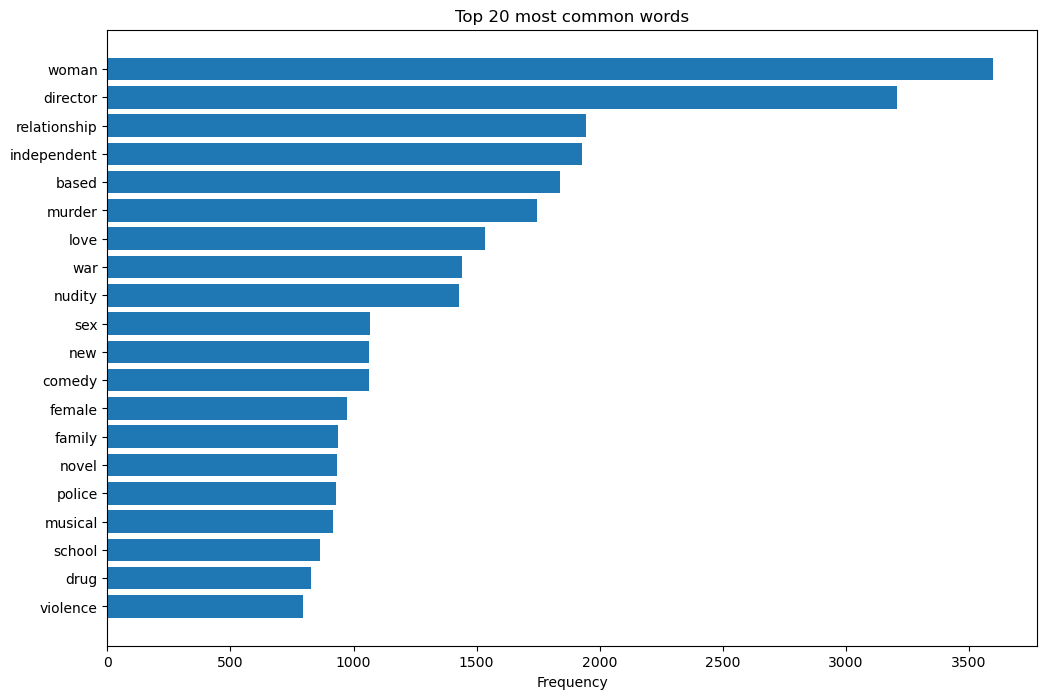

In [30]:
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stopwords_list = list(ENGLISH_STOP_WORDS)
stopwords_list.extend(['film', 'movie'])
# Analyze text data
text_data = df_keywords['keywords'].dropna().tolist()
cleaned_text_data = [doc.replace(',', '') for doc in text_data] 
words = [word for doc in text_data for word in doc.replace(',', '').split() if word.lower() not in stopwords_list]
word_freq = Counter(words)

# Plot the most common words
common_words = word_freq.most_common(20)
words, counts = zip(*common_words)
plt.figure(figsize=(12, 8))
plt.barh(words, counts)
plt.xlabel('Frequency')
plt.title('Top 20 most common words')
plt.gca().invert_yaxis()
plt.show()

In [31]:
#TF-IDF Matrix
#Trains a model whose vectors size is 5000, composed by the main unigrams, bigrams and, trigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 3),
                     min_df=0.03,
                     max_df=0.9,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = df_movies['id'].tolist()

#Vectorisation on keywords and genres
#tfidf_matrix = vectorizer.fit_transform(df_movies['keywords'] + "" + df_movies['genres']) 

#Vectorisation on keywords
tfidf_matrix = vectorizer.fit_transform(df_movies['keywords']) 

tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_matrix

<44555x19 sparse matrix of type '<class 'numpy.float64'>'
	with 42680 stored elements in Compressed Sparse Row format>

In [32]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['movieId'])
    
    user_item_strengths = np.array(interactions_person_df['rating']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_item_strengths_weighted_avg = np.asarray(user_item_strengths_weighted_avg).reshape(1, -1)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_train_df[interactions_train_df['movieId'] \
                                                   .isin(df_movies['id'])].set_index('userId')
    
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [33]:
user_profiles = build_users_profiles()
len(user_profiles)

668

In [34]:
mykeywordsprofile = user_profiles[15]
print(mykeywordsprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles[15].flatten().tolist()), key=lambda x: -x[1])[:10],
             columns=['token', 'relevance'])

(1, 19)


,token,relevance
0,relationship,0.384646
1,murder,0.371169
2,love,0.365630
3,new,0.292904
4,based,0.269649
5,war,0.264932
6,woman,0.264717
7,life,0.225949
8,world,0.206668
9,director,0.198545


In [35]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['movieId', 'recStrengthCB']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'movieId', 
                                                          right_on = 'id')[['movieId',\
                                                                            'title',\
                                                                            'genres',\
                                                                            'overview',\
                                                                            'recStrengthCB']]


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(df_movies)

In [36]:
#TFIDF includes Genre and Keywords

In [37]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    print('Evaluating Content-Based Filtering model...')
    cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
    print('\nGlobal metrics:\n%s' % cb_global_metrics)

cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
667 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.06576897395949255, 'recall@10': 0.06654796349877587}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
91,17,17,179,0.094972,0.094972,564
26,6,6,150,0.040000,0.040000,547
46,6,6,113,0.053097,0.053097,15
40,8,8,110,0.072727,0.072727,73
20,7,7,108,0.064815,0.064815,452
142,9,9,103,0.087379,0.087379,468
57,7,7,97,0.072165,0.072165,624
76,5,5,93,0.053763,0.053763,311
53,6,6,88,0.068182,0.068182,509
188,11,11,86,0.127907,0.127907,30


# 

# Hybrid model

In [38]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df, cb_ensemble_weight=1.0, cf_ensemble_weight=1.0):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.cb_ensemble_weight = cb_ensemble_weight
        self.cf_ensemble_weight = cf_ensemble_weight
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'outer', 
                                   left_on = 'movieId', 
                                   right_on = 'movieId').fillna(0.0)
        
        #Computing a hybrid recommendation score based on CF and CB scores
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF'] 
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCB'] * self.cb_ensemble_weight) \
                                     + (recs_df['recStrengthCF'] * self.cf_ensemble_weight)
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'movieId', 
                                                          right_on = 'id')[['movieId',\
                                                                            'title',\
                                                                            'genres',\
                                                                            'overview',\
                                                                            'recStrengthHybrid']]


        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, df_movies,
                                             cb_ensemble_weight=1.0, cf_ensemble_weight=100.0)

In [39]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    print('Evaluating Hybrid model...')
    hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)
    print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
    
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
667 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.8926107277987981, 'recall@10': 0.8946138437569553}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
91,125,125,179,0.698324,0.698324,564
26,72,72,150,0.480000,0.480000,547
46,94,94,113,0.831858,0.831858,15
40,88,88,110,0.800000,0.800000,73
20,83,85,108,0.768519,0.787037,452
142,85,85,103,0.825243,0.825243,468
57,68,68,97,0.701031,0.701031,624
76,83,83,93,0.892473,0.892473,311
53,72,73,88,0.818182,0.829545,509
188,59,59,86,0.686047,0.686047,30


# 

# Testing Model

In [40]:
def inspect_interactions(user_id, test_set):
    if test_set==1:
        interactions_df = interactions_test_indexed_df[interactions_test_indexed_df.index == user_id]\
            .merge(df_movies[['id', 'title', 'genres', 'overview']], 
                   left_on='movieId', 
                   right_on='id', 
                   how='left').sort_values(by='rating', ascending=False)
    elif test_set==0:
        interactions_df = interactions_train_indexed_df[interactions_train_indexed_df.index == user_id]\
            .merge(df_movies[['id', 'title', 'genres', 'overview']], 
                   left_on='movieId', 
                   right_on='id', 
                   how='left').sort_values(by='rating', ascending=False)
    
    return interactions_df[['movieId','title','genres','overview','rating']]

In [41]:
#avoid watched movies
items_to_ignore = inspect_interactions(1, test_set=0)['movieId'].tolist() 

#see user interacted movies
inspect_interactions(1, test_set=0)

,movieId,title,genres,overview,rating
4,2105,American Pie,"Comedy, Romance","At a high-school party, four friends find that...",2.321928
1,2455,Confidentially Yours,"Drama, Comedy, Crime",Claude Massoulier is murdered while hunting at...,1.807355
2,2294,Jay and Silent Bob Strike Back,Comedy,When Jay and Silent Bob learn that their comic...,1.584963
3,2193,My Tutor,"Comedy, Drama, Romance",High school senior Bobby Chrystal fails his Fr...,1.584963
0,1405,Greed,"Drama, History",Greed is the classic 1924 silent film by Erich...,1.000000


## Collaborative Filtering Model

In [42]:
cf_recommender_model.recommend_items(1, items_to_ignore, topn=100, verbose=True)

,movieId,title,genres,overview,recStrengthCF
0,1374,Rocky IV,Drama,Rocky must come out of retirement to battle a ...,0.327125
1,1127,Princesses,Drama,"Set in Spain, the story is about friendship an...",0.325666
2,596,The Grapes of Wrath,Drama,Tom Joad returns to his home after a jail sent...,0.325485
3,1580,Rope,"Crime, Drama, Mystery, Thriller","Two young men strangle their ""inferior"" classm...",0.325107
4,2140,Kiss of the Dragon,"Action, Crime, Thriller","Liu Jian, an elite Chinese police officer, com...",0.325006
...,...,...,...,...,...
95,2459,An Elephant Can Be Extremely Deceptive,Comedy,Etienne falls in love with a sexy woman he mee...,0.320461
96,1597,Meet the Parents,"Comedy, Romance","Greg Focker is ready to marry his girlfriend, ...",0.320422
97,3476,That Most Important Thing: Love,"Drama, Romance","Servais Mont, a photographer, meets Nadine Che...",0.320369
98,2288,Closer,"Drama, Romance","A witty, romantic, and very dangerous love sto...",0.320355


## Popularity Model

In [72]:
popularity_model.recommend_items(1, items_to_ignore, topn=100, verbose=True)

,movieId,title,genres,overview,rating
0,296,Terminator 3: Rise of the Machines,"Action, Thriller, Science Fiction",It's been 10 years since John Connor saved Ear...,767.563328
1,318,The Million Dollar Hotel,"Drama, Thriller",The Million Dollar Hotel starts with a jump fr...,759.420475
2,593,Solaris,"Drama, Science Fiction, Adventure, Mystery",Ground control has been receiving strange tran...,704.557291
3,260,The 39 Steps,"Action, Thriller, Mystery","While on vacation in London, Canadian Richard ...",683.097729
4,480,Monsoon Wedding,"Comedy, Drama, Romance",From an exciting Indian wedding comes a relati...,598.949794
...,...,...,...,...,...
95,923,Dawn of the Dead,Horror,During an ever-growing epidemic of zombies tha...,199.451258
96,337,Monsieur Ibrahim,Drama,Monsieur Ibrahim is a story about a young Jewi...,196.646760
97,17,The Dark,"Horror, Thriller, Mystery",Adèle and her daughter Sarah are traveling on ...,195.250543
98,440,Aliens vs Predator: Requiem,"Fantasy, Action, Science Fiction, Thriller, Ho...","A sequel to 2004's Alien vs. Predator, the ico...",195.224583


## Content Based Model

In [43]:
content_based_recommender_model.recommend_items(1, items_to_ignore, topn=100, verbose=True)

,movieId,title,genres,overview,recStrengthCB
0,54102,Generation Kill,"Drama, History, War",Marines prepare to invade Iraq at the beginnin...,0.835205
1,404584,From a House on Willow Street,"Action, Horror","After a young woman is kidnapped, her captors ...",0.835205
2,22797,The Butcher Boy,"Comedy, Drama","Francie and Joe live the usual playful, fantas...",0.835205
3,57440,After School,Mystery|Comedy|Drama,A heady brain teaser of a film with unexpected...,0.805305
4,67595,The Positively True Adventures of the Alleged ...,"Comedy, Drama",When her daughter Shanna is disqualified from ...,0.778161
...,...,...,...,...,...
95,11892,Murder by Numbers,"Crime, Drama, Thriller",Tenacious homicide detective Cassie Mayweather...,0.631932
96,40373,Waiting for Godot,Drama,"Two tramps wait for a man named Godot, but ins...",0.631932
97,50479,Avalon High,"Drama, Family, Fantasy",Disney Channel's production of Julie Sherman W...,0.631932
98,827,Diabolique,"Drama, Horror, Thriller","In this classic of French suspense, the cruel ...",0.631932


## Hybrid Model

In [44]:
hybrid_recommender_model.recommend_items(1, items_to_ignore, topn=100, verbose=True)

,movieId,title,genres,overview,recStrengthHybrid
0,2770,American Pie 2,"Comedy, Romance",The whole gang are back and as close as ever. ...,32.811468
1,2640,Heathers,"Thriller, Comedy, Drama",A girl who halfheartedly tries to be part of t...,32.784355
2,1374,Rocky IV,Drama,Rocky must come out of retirement to battle a ...,32.712471
3,1127,Princesses,Drama,"Set in Spain, the story is about friendship an...",32.566570
4,1968,Fools Rush In,"Drama, Comedy, Romance",Alex Whitman (Matthew Perry) is a designer fro...,32.552103
...,...,...,...,...,...
95,2395,Asterix at the Olympic Games,"Fantasy, Adventure, Comedy, Family",Astérix and Obélix have to win the Olympic Gam...,32.098059
96,1377,Houseboat,"Comedy, Drama, Family, Romance",An Italian socialite on the run signs on as ho...,32.093570
97,1213,The Talented Mr. Ripley,"Thriller, Crime, Drama",Tom Ripley is a calculating young man who beli...,32.087861
98,1965,A Perfect Murder,"Crime, Thriller, Drama",Millionaire industrialist Steven Taylor is a m...,32.081199


# 

# Comparing Model

In [69]:
global_metrics_df = pd.DataFrame([pop_global_metrics, cf_global_metrics, cb_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName') \
                        .sort_values(by='recall@5', ascending=True)
global_metrics_df

,recall@5,recall@10
modelName,,
Content-Based,0.065769,0.066548
Hybrid,0.892611,0.894614
Collaborative Filtering,0.943356,0.980859
Popularity,0.977187,0.999110


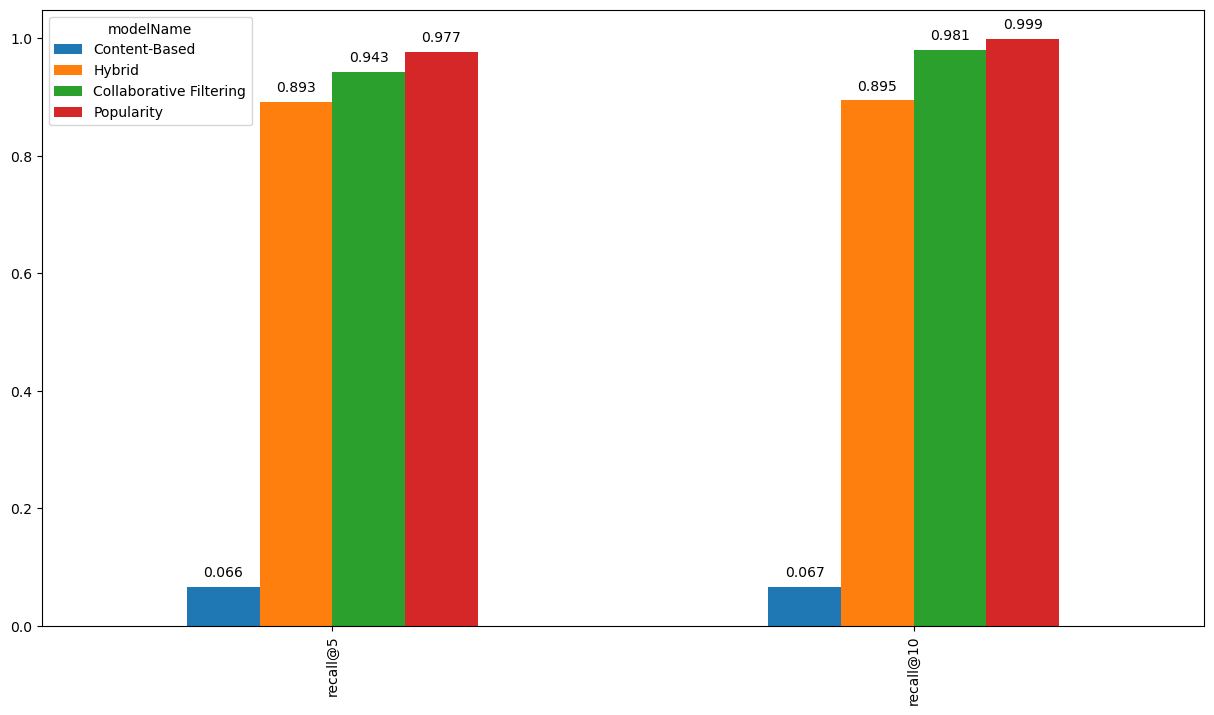

In [70]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

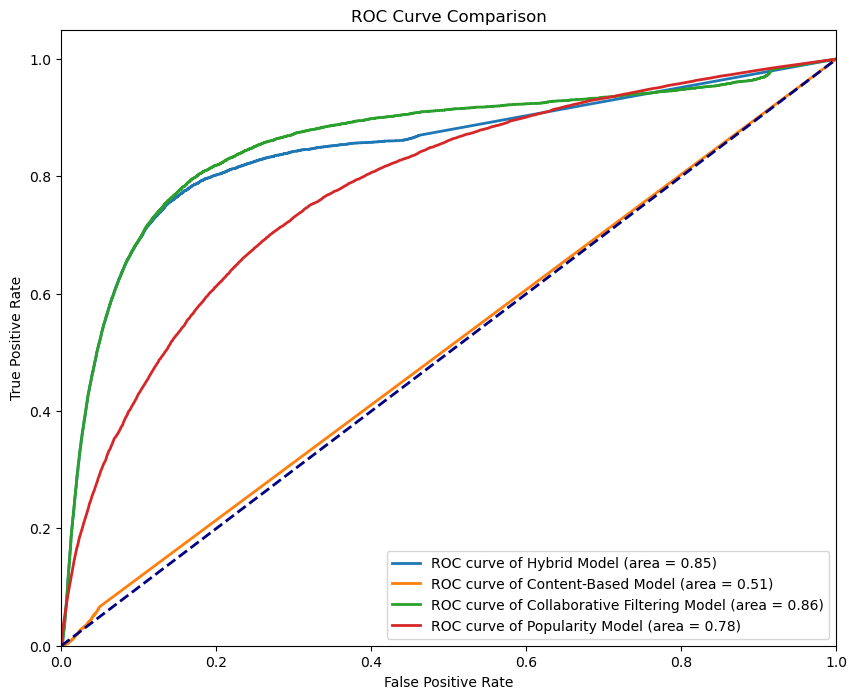

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(test_data, models, model_names, score_columns):
    plt.figure(figsize=(10, 8))

    for model, name, score_col in zip(models, model_names, score_columns):
        y_true = []
        y_scores = []

        user_ids = test_data['userId'].unique()
        item_ids = test_data['movieId'].unique()

        for user_id in user_ids:
            actual_interactions = set(test_data[test_data['userId'] == user_id]['movieId'])
            all_items = pd.DataFrame(item_ids, columns=['movieId'])
            predicted_scores = model.recommend_items(user_id, topn=None, verbose=False)
            all_items = all_items.merge(predicted_scores, on='movieId', how='left').fillna(0)
            all_items['true_label'] = all_items['movieId'].apply(lambda x: 1 if x in actual_interactions else 0)
            y_true.extend(all_items['true_label'])
            y_scores.extend(all_items[score_col])

        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve of {name} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")
    plt.show()

# Models, their names, and score columns
models = [hybrid_recommender_model, content_based_recommender_model, cf_recommender_model, popularity_model]
model_names = ['Hybrid Model', 'Content-Based Model', 'Collaborative Filtering Model', 'Popularity Model']
score_columns = ['recStrengthHybrid', 'recStrengthCB', 'recStrengthCF', 'rating']

# Call the function
plot_roc_curves(interactions_test_df, models, model_names, score_columns)